# Kalman Filter
An introduction: 

https://www.youtube.com/playlist?list=PLn8PRpmsu08pzi6EMiYnR-076Mh-q3tWr

---
The KF estimates the state variable (truth) $x$,  
which is assumed to "evolve" according to some linear "dynamics":
$$ x_{k} = F_{k-1} x_{k-1} + q_{k-1} \, , \qquad (\text{Dyn}) $$
where $q_{k-1} \sim \mathcal{N}(0, Q)$ is known dynamic process noise,  
and $k = 1,2,3,\ldots$ denotes the time indices.


The KF recursively (for increasing $k$) estimates $x_k$.
It repeats a cycle consisting of two steps :
 
#### The forecast step
"propagates" the estimate (the pdf) of the state;
since $x_k$ obeys (Dyn),  
   if $\; p(x_{k-1}) = \mathcal{N}(x_{k-1} \mid \; \phantom{F_{k-1}}\hat{x}_{k-1}^a,\; \phantom{F_{k-1}^2} P_{k-1}^a) \, ,$
   for some $\hat{x}_{k-1}^a, \, P_{k-1}^a$,   
   then  $p(x_k)     = \mathcal{N}(x_k \; \; \, \mid \;  \underbrace{F_{k-1}
   \hat{x}_{k-1}^a}_{{\hat{x}_{k}}^f},\; \underbrace{F_{k-1}^2 P_{k-1}^a + Q}_{{P_k}^f}) \, .$  
The KF forecast step amounts to the computation of the moments with superscript $f$. 

 
#### The analysis step
"updates" the prior (forecast), $\mathcal{N}(x_k \mid \; \hat{x}_k^f,\; P_k^f)$,  
based on the likelihood, $\quad\;\;\;\, \mathcal{N}(y_k \mid \, x_k, \; R)$,  
into the posterior (analysis), $\; \; \, \mathcal{N}(x_k \mid \; \hat{x}_{k}^a, \, P_{k}^a)$.  
The update formulae was derived as the Gaussian-Gaussian Bayes' rule.

## Ensemble Kalman Filter

### Initialize Step

$$\boldsymbol\chi \sim \mathcal{N}(\mathbf{x}_0, \mathbf{P}_0)$$

This says to select the sigma points from the filter's initial mean and covariance.

### Predict Step

$$
\begin{aligned}
\boldsymbol\chi &= f(\boldsymbol\chi, \mathbf{u}) + v_Q \\
\mathbf{x} &= \frac{1}{N} \sum_1^N \boldsymbol\chi
\end{aligned}
$$

That is short and sweet, but perhaps not entirely clear. The first line passes all of the sigma points through a use supplied state transition function and then adds some noise distributed according to the $\mathbf{Q}$ matrix. 

We can now optionally compute the covariance of the mean. The algorithm does not need to compute this value, but it is often useful for analysis. The equation is

$$\mathbf{P} = \frac{1}{N-1}\sum_1^N[\boldsymbol\chi-\mathbf{x}^-][\boldsymbol\chi-\mathbf{x}^-]^\mathsf{T}$$

$\boldsymbol\chi-\mathbf{x}^-$ is a one dimensional vector, so we will use `numpy.outer` to compute the $[\boldsymbol\chi-\mathbf{x}^-][\boldsymbol\chi-\mathbf{x}^-]^\mathsf{T}$ term.

### Update Step

In the update step we pass the sigma points through the measurement function, compute the mean and covariance of the sigma points, compute the Kalman gain from the covariance, and then update the Kalman state by scaling the residual by the Kalman gain. The equations are

$$
\begin{aligned}
\boldsymbol\chi_h &= h(\boldsymbol\chi, u)\\
\mathbf{z}_{mean} &= \frac{1}{N}\sum_1^N \boldsymbol\chi_h \\ \\
\mathbf{P}_{zz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi_h - \mathbf{z}_{mean}][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T} + \mathbf{R} \\
\mathbf{P}_{xz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi - \mathbf{x}^-][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T} \\
\\
\mathbf{K} &= \mathbf{P}_{xz} \mathbf{P}_{zz}^{-1}\\ 
\boldsymbol\chi & = \boldsymbol\chi + \mathbf{K}[\mathbf{z} -\boldsymbol\chi_h + \mathbf{v}_R] \\ \\
\mathbf{x} &= \frac{1}{N} \sum_1^N \boldsymbol\chi \\
\mathbf{P} &= \mathbf{P} - \mathbf{KP}_{zz}\mathbf{K}^\mathsf{T}
\end{aligned}
$$

Let's just go line by line.

The first line,

$$\boldsymbol\chi_h = h(\boldsymbol\chi, u),$$

just passes the sigma points through the measurement function $h$. We name the resulting points $\chi_h$ to distinguish them from the sigma points. 

The next line computes the mean of the measurement sigmas.

$$\mathbf{z}_{mean} = \frac{1}{N}\sum_1^N \boldsymbol\chi_h$$

In Python we write

```python
z_mean = np.mean(sigmas_h, axis=0)
```
    
Now that we have the mean of the measurement sigmas we can compute the covariance for every measurement sigma point, and the *cross variance* for the measurement sigma points vs the sigma points. That is expressed by these two equations

$$
\begin{aligned}
\mathbf{P}_{zz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi_h - \mathbf{z}_{mean}][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T} + \mathbf{R} \\
\mathbf{P}_{xz} &= \frac{1}{N-1}\sum_1^N [\boldsymbol\chi - \mathbf{x}^-][\boldsymbol\chi_h - \mathbf{z}_{mean}]^\mathsf{T}
\end{aligned}$$

Computation of the Kalman gain is straightforward $\mathbf{K} = \mathbf{P}_{xz} \mathbf{P}_{zz}^{-1}$.

Next, we update the sigma points with

$$\boldsymbol\chi  = \boldsymbol\chi + \mathbf{K}[\mathbf{z} -\boldsymbol\chi_h + \mathbf{v}_R]$$ 

Here $\mathbf{v}_R$ is the perturbation that we add to the sigmas.

Our final step is recompute the filter's mean and covariance.

```python
    x = np.mean(sigmas, axis=0)
    P = self.P - dot(K, P_zz).dot(K.T)
```

In [1]:
from numpy.random import randn
import numpy as np
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

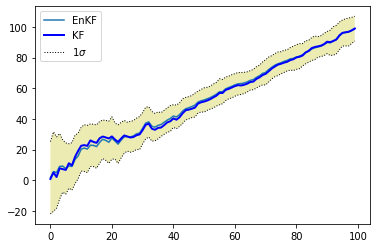

In [2]:
def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    return np.dot(F, x)
    
F = np.array([[1., 1.],[0., 1.]])

x = np.array([0., 1.])
P = np.eye(2) * 100.
enf = EnKF(x=x, P=P, dim_z=1, dt=1., N=20, hx=hx, fx=fx)

std_noise = 10.
enf.R *= std_noise**2
enf.Q = Q_discrete_white_noise(2, 1., .001)

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([x]).T
kf.F = F.copy()
kf.P = P.copy()
kf.R = enf.R.copy()
kf.Q = enf.Q.copy()
kf.H = np.array([[1., 0.]])

measurements = []
results = []
ps = []
kf_results = []

zs = []
for t in range (0,100):
    # create measurement = t plus white noise
    z = t + randn()*std_noise
    zs.append(z)

    enf.predict()
    enf.update(np.asarray([z]))
    
    kf.predict()
    kf.update(np.asarray([[z]]))

    # save data
    results.append (enf.x[0])
    kf_results.append (kf.x[0,0])
    measurements.append(z)
    ps.append(3*(enf.P[0,0]**.5))

results = np.asarray(results)
ps = np.asarray(ps)

plt.plot(results, label='EnKF')
plt.plot(kf_results, label='KF', c='b', lw=2)
# bp.plot_measurements(measurements)
plt.plot (results - ps, c='k',linestyle=':', lw=1, label='1$\sigma$')
plt.plot(results + ps, c='k', linestyle=':', lw=1)
plt.fill_between(range(100), results - ps, results + ps, facecolor='y', alpha=.3)
plt.legend(loc='best');

# Ensemble Kalman Filter

## Model definition

In [3]:
from dapper import *
import numpy as np

Initializing DAPPER...

but is not supported by current backend: module://ipykernel.pylab.backend_inline.
Try another backend in your settings, e.g., mpl.use('Qt5Agg').
...Done
PS: Turn off this message in your configuration: dpr_config.ini


In [4]:
def gaussian(x, mu, sig):
    c=np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    c=c/np.max(c)
    return c

Nx = 100
a = 1
deltax=1./Nx

x = linspace(0,1,Nx+1)

u0 = gaussian(x,0.2,0.05)

def dudt(u):
    dudt = np.zeros_like(u)
    for i in range(1,u.shape[0]):
        dudt[i]=-a/deltax/2*(u[i]**2-u[i-1]**2)
    return dudt

step = with_rk4(dudt,autonom=True)

## Model demo

Simulating: 100%|██████████| 100/100 [00:00<00:00, 1781.03it/s]


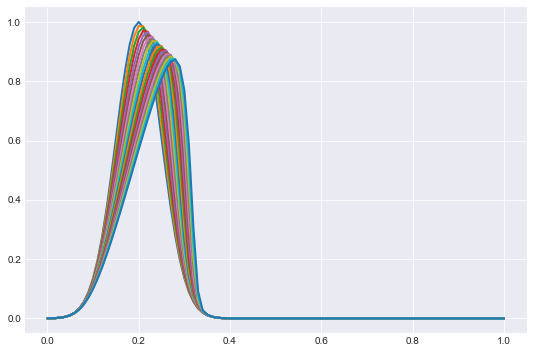

In [11]:
simulator = with_recursion(step, prog="Simulating")

dt = .001
K  = int(.1 / dt)    # number of steps
xx = simulator(u0, K, t0=0, dt=dt)

##
fig, ax = freshfig(2,(9,6))
# ax.plot(linspace(0,K*dt,K+1),xx)
fig = ax.plot(x,xx[::5,:].T)

## HMM model

In [6]:
# Settings not taken from anywhere
# dt has been chosen after noting that 
# using dt up to 0.7 does not change the chaotic properties much,
# as adjudged with eye-ball and Lyapunov measures.

t = Chronology(K=100,T=0.1,dkObs=10, Tplot=0)

Nx = len(x)

Dyn = {
    'M'    : Nx,
    'model': step,
#    'linear': dstep_dx,
    'noise': 0.1
    }

X0 = GaussRV(mu=u0,C=0.002**2)

jj = arange(0,Nx,2)
Obs = partial_Id_Obs(Nx,jj)
Obs['noise'] = 1e-10 #0.01**2

HMM = HiddenMarkovModel(Dyn,Obs,t,X0)

####################
# Suggested tuning
####################
# Not carefully tuned:
# cfgs += EnKF_N(N=6)
# cfgs += ExtKF(infl=1.02)

## Data assimilation

In [7]:
# Simulate synthetic truth (xx) and noisy obs (yy)
xx,yy = simulate(HMM)

# Specify a DA method configuration
# config = EnKF('Sqrt', N=10)
# config = Climatology()
config = EnKF('Sqrt', N=100, store_u=True)
# config = EnKF_N(N=40, store_u=True)
# config = Var3D()
# config = PartFilt(N=100,reg=2.4,NER=0.3)

# Turn on liveplotting
config.liveplotting = True

# Assimilate yy, knowing the HMM; xx is used for assessment.
stats = config.assimilate(HMM,xx,yy)

EnKF: 100%|██████████| 100/100 [00:00<00:00, 236.38it/s]


## Visualization

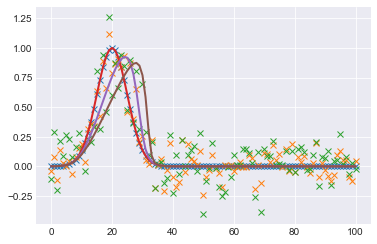

In [12]:
plt.plot(stats.mu.u[::50,:].T,'x')
plt.plot(xx[::50,:].T,'-')

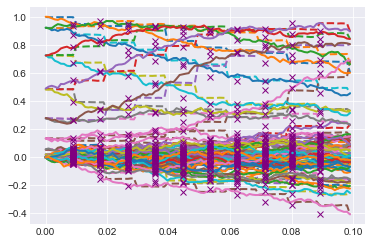

In [14]:
time=np.arange(0,t.T,t.T/(K+1))
fig=plt.plot(time,stats.mu.u[:,jj],'--')
fig=plt.plot(time,stats.xx[:,jj],'-')
fig=plt.plot(time[t.KObs:-t.KObs:t.KObs],yy,'x',color='purple')

In [16]:
# Average stats time series
avrgs = stats.average_in_time()

# Print averages
print_averages(config,avrgs,[],['rmse_a','rmv_a'])

# Replay liveplotters -- can adjust speed, time-window, etc.
# replay(stats,figlist="all")

# Further diagnostic plots:
# plot_rank_histogram(stats)
# plot_err_components(stats)
# plot_hovmoller(xx)

# Explore objects:
# print(HMM)
# print(config)
# print(stats)
# print(avrgs)

     |  rmse_a ±      rmv_a ±
---  -  -----------  -------------
[0]  |  0.1235 0.03  0.0196 0.0008
